In [1]:
from aux_train import *
from aux_plot import *
from aux_func_V3 import *

In [45]:
# with open('C:\\Jupyter\\Edge detection\\WENO-DS reescrito\\Datasets\\Dados temporais Tatiana transp.bkp','rb') as file:
#      Δx=2/128
#      CFL=0.5
#      Δt=0.4/100
#      fronteira=FronteiraPeriodica
#      y=dill.load(file)
#      equation=transp_equation
equation_name='transp_equation'
poly_grade=1
seno_ampli=1
gauss_var=1
seizures=1

data_temporal,data_spatial,data_base,Δx,Δt,CFL,fronteira,equation=load_dataset(f'datasets/equation={equation_name} polys grau={poly_grade} seno_ampli={seno_ampli} gauss_var={gauss_var} seizure={seizures}')
y=data_temporal

'Δx': 0.015625
'Δt': 0.004
'CFL': 0.5
'fronteira': <function FronteiraPeriodica at 0x0000015D86B7F550>
'equation': <class 'aux_equation.transp_equation'>
'seed': None



In [46]:
print(Δt**3)
print(Δx**5)

6.4e-08
9.313225746154785e-10


In [47]:
def loop_wrapper(func):
    def loop_func(u0,Δx):
        u=u0+0
        for i in range(y.shape[1]-1):
            u=func(u,Δx)
        return u
    return loop_func

In [48]:
WENO_Z_ref_sim=simulation(API_Numpy,equation,WENO_Z)
WENO_Z_ref=lambda u0, Δx:WENO_Z_ref_sim.Sim(u0,Δt, Δx, CFL, fronteira)
WENO_JS_ref_sim=simulation(API_Numpy,equation,WENO_JS)
WENO_JS_ref=lambda u0, Δx:WENO_JS_ref_sim.Sim(u0,Δt, Δx, CFL, fronteira)# Criando uma camada de Burgers que integra o WENO à rede neural
Sim_layer = WENO_temporal_layer(equation,WENO_Z,Δt, Δx, fronteira,regul_weight=0,ativ_func=tf.nn.sigmoid,p=2,conv_size=5)
WENO_network=tf.function(lambda u0, Δx:Sim_layer.Sim(u0,Δt, Δx, CFL, fronteira))

In [12]:
# Sim, Sim_step, DerivadaEspacial, Get_weights=create_simulation(API_Numpy,burgers_equation,WENO_Z)
# WENO_Z_ref=lambda u0, Δx, Δt:Sim(u0,Δt, Δx, CFL, FronteiraPeriodica)
# Sim, Sim_step, DerivadaEspacial, Get_weights=create_simulation(API_Numpy,burgers_equation,WENO_JS)
# WENO_JS_ref=lambda u0, Δx, Δt:Sim(u0,Δt, Δx, CFL, FronteiraPeriodica)
# # Criando uma camada de Burgers que integra o WENO à rede neural
# Sim_layer = WENO_temporal(Δx, CFL, Δt, FronteiraFixa,burgers_equation,WENO_JS,regul_weight=0)
# WENO_network=tf.function(lambda u0, Δx, Δt:Sim_layer.Sim(u0,Δt, Δx, CFL, FronteiraPeriodica))

In [49]:
indice = np.arange(y.shape[0])
np.random.shuffle(indice)
data_x = y.astype('float64')[indice]
data_y = y.astype('float64')[indice]

In [9]:
# plt.figure(figsize=(6.4*5,6.4*2))
# for i,j in zip(range(5),np.random.randint(0,50,5)):
#     plt.subplot(2, 5, i%5+1)
#     plt.ylim(-2,2)
#     plt.plot(data_x[j,0])
#     plt.subplot(2, 5, 5+i%5+1)
#     plt.ylim(-2,2)
#     plt.plot(data_y[j,100])
# plt.savefig('tatiana dataset.png')

In [50]:
# Conjunto de dados de treino
# train_x = data_x[:-40,:-1]
# train_y = data_x[:-40,1:]
# k=10
# data_cutted=np.split(data_x,np.arange(k+1,data_x.shape[1],k+1),axis=1)
# data_cutted=np.concatenate([i for i in data_cutted if i.shape[1]==k+1],axis=0)
train_x = data_x[:,:-1]
train_y = data_y[:,1:]
#train_x=API_Numpy.concat(API_Numpy.unstack(train_x,1),axis=0)
#train_y=API_Numpy.concat(API_Numpy.unstack(train_y,1),axis=0)

# test_x = data_x[-5000:]
# test_y = data_y[-5000:]

# Conjunto de dados de validação
# test_x = data_x[-40:,:-1]
# test_y = data_x[-40:,1:]

In [66]:
# Definindo o input da rede e o otimizador de treino
input_x   = keras.layers.Input(train_x.shape[1:], dtype='float64')
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

#final_x=Sim_layer.Sim_step_graph(input_x,Δt, Δx, fronteira)
# output_x=[input_x]
# for i in range(train_y.shape[1]):
#     print(i,end='\r')
#     output_x.append(Sim_layer(output_x[-1],Δt, Δx, fronteira))

# # Criando a rede neural
# Network = keras.Model(input_x, tf.stack(output_x[1:],axis=-2))

output_x=input_x
output_x=keras.layers.TimeDistributed(Sim_layer)(output_x)

# Criando a rede neural
Network = keras.Model(input_x, output_x)

# Configurando a função de perda e o otimizador


Network.compile(loss=MES_relative(Δx/2), optimizer=optimizer, metrics=['mean_absolute_error'])

In [67]:
# Treinando a rede neural
history=Network.fit(
            train_x                           , # Dados de treino
            train_y                           , # Dados de treino
#            validation_data = (test_x, test_y), # Dados de validação
            batch_size      = 4            , # Tamanho do batch
            epochs          = 90            , # Número de epochs
#            steps_per_epoch = 90             , # Número de batchs por epoch
            shuffle         = True              # Aleatorização dos batchs
        )

# Batch: pacote de dados utilizados antes de uma atualização dos pesos da rede
# Epoch: rodada de treino da rede neural, em geral percorre todo o conjunto de dados

Epoch 1/90
113/113 [==============================] - 136s 1s/step - loss: 3.4376 - mean_absolute_error: 0.0694
Epoch 2/90
113/113 [==============================] - 124s 1s/step - loss: 3.4052 - mean_absolute_error: 0.0694
Epoch 3/90
113/113 [==============================] - 123s 1s/step - loss: 3.3828 - mean_absolute_error: 0.0693
Epoch 4/90
  3/113 [..............................] - ETA: 2:02 - loss: 2.8910 - mean_absolute_error: 0.0742

KeyboardInterrupt: 

In [68]:
Sim_Z=simulation(API_Numpy,transp_equation,WENO_Z)

In [69]:
def f_test(x):
    z = tf.constant(-0.7, dtype=float_pres)
    δ = tf.constant(0.005, dtype=float_pres)
    β = tf.math.log(tf.constant(2.0, dtype=float_pres))/(36.0*(δ**2.0))
    a = tf.constant(0.5, dtype=float_pres)
    α = tf.constant(10, dtype=float_pres)
    
    def G(x, β, z):
        return tf.math.exp(-β*(x-z)**2)
    
    def F(x, α, a):
        return tf.math.sqrt(tf.math.maximum(1-(α**2)*((x-a)**2),0))
    
    f1 = (G(x, β, z-δ) + 4*G(x, β, z) + G(x, β, z+δ))/6 # x in [-0.8, -0.6]
    f2 = 1                                              # x in [-0.4, -0.2]
    f3 = 1-tf.math.abs(10*(x-0.1))                      # x in [ 0.0,  0.2]
    f4 = (F(x, α, a-δ) + 4*F(x, α, a) + F(x, α, a+δ))/6 # x in [ 0.4,  0.6]
    f5 = 0                                              # otherwise
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, -0.8),
        tf.math.less_equal(x, -0.6)
    )
    f1 = f1*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, -0.4),
        tf.math.less_equal(x, -0.2)
    )
    f2 = f2*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, 0.0),
        tf.math.less_equal(x, 0.2)
    )
    f3 = f3*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, 0.4),
        tf.math.less_equal(x, 0.6)
    )
    f4 = f4*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    f = f1 + f2 + f3 + f4 + f5
    
    return f

In [70]:
fxs=np.stack(fxs_list,axis=0)
fxs_dense=np.stack(fxs_dense_list,axis=0)

In [71]:
import plotly.graph_objects as go

In [72]:
Δx=0.01
Δt=Δx*CFL
total_time=int(0.25/Δt)
time=0

x,fx=create_f_points(f_test=f_test,Δx=Δx)
x_dense,fx_dense=create_f_points(f_test=f_test,Δx=Δx/10)
prev_fx_list=[fx[...]]
fxs_list=[fx[...]]
fxs_dense_list=[fx_dense[...]]
for i in range(total_time):
    if(i%10==0):
        print(time,end='\r')

    prev_fx_list.append(Sim_layer.Sim_step(prev_fx_list[-1],Δt, Δx, FronteiraPeriodica))
    fxs_dense_list.append(Sim_Z.Sim(fxs_dense_list[-1],Δt,Δx/10,CFL,FronteiraPeriodica))
    fxs_list.append(Sim_Z.Sim(fxs_list[-1],Δt,Δx,CFL,FronteiraPeriodica))

    fig=go.Figure()
    fig.add_trace(go.Scatter(x=x_dense, y=fxs_dense[-1,0],
                        mode='lines',
                        name='Sol. ref.'))
    fig.add_trace(go.Scatter(x=x, y=fxs[-1,0],
                        mode='lines',
                        name='WENO-Z'))
    fig.add_trace(go.Scatter(x=x, y=prev_fx_list[-1][0],
                    mode='lines',
                    name='WENO-DS'))
    
    plot_all_registry.append(fig)
    time+=Δt

In [73]:
plot_all_registry[1]

In [23]:
print(np.mean(np.abs(WENO_Z_ref(data_x[:,:10],Δx)-train_y)))
print(np.mean(np.abs(Network(train_x,Δx)-train_y)))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
[[0.004 0.004 0.004 ... 0.004 0.004 0.004]
 [0.004 0.004 0.004 ... 0.004 0.004 0.004]
 [0.004 0.004 0.004 ... 0.004 0.004 0.004]
 ...
 [0.004 0.004 0.004 ... 0.004 0.004 0.004]
 [0.004 0.004 0.004 ... 0.004 0.004 0.004]
[[0.004 0.004 0.004 ... 0.004 0.004 0.004]]
 [0.004 0.004 0.004 ... 0.004 0.004 0.004]
 [0.004 0.004 0.004 ... 0.004 0.004 0.004]
 ...
 [0.004 0.004 0.004 ... 0.004 0.004 0.004]
 [0.004 0.004 0.004 ... 0.004 0.004 0.004]
0.0019759249484692766.. 0.004 0.004 0.004]]
0.0038458524543932794


In [25]:
train_y.shape

(150, 10, 128)

In [24]:
WENO_Z_ref(data_x[:,:10],Δx).shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
[[0.004 0.004 0.004 ... 0.004 0.004 0.004]
 [0.004 0.004 0.004 ... 0.004 0.004 0.004]
 [0.004 0.004 0.004 ... 0.004 0.004 0.004]
 ...
 [0.004 0.004 0.004 ... 0.004 0.004 0.004]
 [0.004 0.004 0.004 ... 0.004 0.004 0.004]
[[0.004 0.004 0.004 ... 0.004 0.004 0.004]]
 [0.004 0.004 0.004 ... 0.004 0.004 0.004]
 [0.004 0.004 0.004 ... 0.004 0.004 0.004]
 ...
 [0.004 0.004 0.004 ... 0.004 0.004 0.004]
 [0.004 0.004 0.004 ... 0.004 0.004 0.004]


(150, 10, 128)

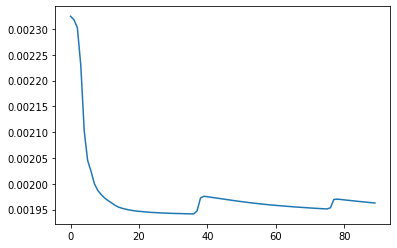

In [26]:
plt.plot(history.history['loss'])

In [42]:
# Salvando os pesos treinados
save=input('Deseja salvar a rede?(Y/N)')
if save=='Y':
    save_model(Network,'Modelos treinados/Modelo Rede temporal sequencial 1')

In [41]:
import os
def save_model(Network,path):
    if not(os.path.isdir(path+'/')):
        os.mkdir(path+'/')
    with open(path+'/config.cfg','wb') as file:
        dill.dump(Network.layers[min([i for i,layer in enumerate(Network.layers) if layer.name=='WENO_layer'])].config,file)
    Network.save_weights(path+'/network.h5')

In [ ]:
# Carregando os pesos treinados
Network.load_weights('Modelos treinados\\Modelo Rede temporal - 5.h5')

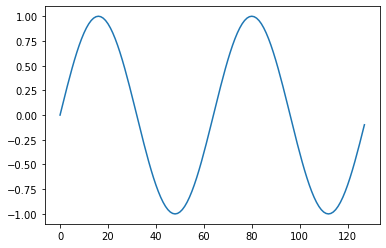

In [27]:
f_test = lambda x: np.sin(2*pi*x) #np.exp(-0.05*(x**2))
plt.plot(f_test(tf.range(-1, 1, Δx, dtype=float_pres)))

In [28]:
f_test(tf.range(-1, 1, Δx, dtype=float_pres))[0]-f_test(tf.range(-1, 1, Δx, dtype=float_pres))[-1]

0.09801714032956076

In [ ]:
0.001**3

1e-09

(20/100)**5

In [ ]:
Δt=0.001
Δt=0.4/1000
Δt=10**-4

equation=equation
equation=transp_equation

def loop_wrapper(func):
    def loop_func(u0,Δx):
        u=u0+0
        #for i in range(int(1/Δt)):
        for i in range(int(5/(9*Δt))):
            u=func(u,Δx)
        return u
    return loop_func

WENO_Z_ref_sim=simulation(API_Numpy,equation,WENO_Z)
WENO_Z_ref=loop_wrapper(lambda u0, Δx:WENO_Z_ref_sim.Sim_step(u0,Δt, Δx, FronteiraPeriodica))
WENO_JS_ref_sim=simulation(API_Numpy,equation,WENO_JS)
WENO_JS_ref=loop_wrapper(lambda u0, Δx:WENO_JS_ref_sim.Sim_step(u0,Δt, Δx, FronteiraPeriodica))
# Criando uma camada de Burgers que integra o WENO à rede neural
Sim_layer = WENO_temporal(Δx, CFL, Δt, FronteiraPeriodica,equation,WENO_Z,regul_weight=0)
WENO_network=loop_wrapper(tf.function(lambda u0, Δx:Sim_layer.Sim_step(u0,Δt, Δx, FronteiraPeriodica)))

In [ ]:
# Definindo o input da rede e o otimizador de treino
input_x   = keras.layers.Input([train_x.shape[1],train_x.shape[2]], dtype='float64')
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

ouput_x=input_x
# ouput_list=[]
# for i in range(train_y.shape[1]):
#     ouput_x=Sim_layer(ouput_x)
#     ouput_list.append(ouput_x+0)
# final_x=tf.stack(ouput_list,axis=1)

timely_layer=keras.layers.TimeDistributed(Sim_layer)
final_x=timely_layer(ouput_x)

# Criando a rede neural
Network = keras.Model(input_x, final_x)
# Configurando a função de perda e o otimizador

Network.compile(loss='MSE', optimizer=optimizer, metrics=['mean_absolute_error'])

In [ ]:
# Carregando os pesos treinados
Network.load_weights('Modelos treinados\\Modelo Rede temporal - 5.h5')

In [ ]:
#np.random.seed(seed=13031998)
n=1

z1=np.random.uniform(size=[n,1],low=1,high=2)
z2=np.random.uniform(size=[n,1],low=10,high=30)
z3=np.random.uniform(size=[n,1],low=1,high=2)

In [ ]:
def f_test(x):
    x_ref=x+1
    #f1=np.where(x_ref<1,z1,0) 
    f2=-np.exp(-z2*((x_ref-1)**2))
    #f3=z3*np.sin(np.pi*x_ref) 

    y=np.concatenate([f2],axis=0)
    return y

In [ ]:
# Calculando os erros de previsão utilizando o WENO-Z em uma malha mais fina 
# como solução de referência e depois calculando o WENO-Z e o WENO-Z com a 
# modificação da rede neural numa malha mais grossa
sizes=np.arange(30,100+1,10)
error1=[]
error2=[]
error3=[]
k=10
for i in sizes:
    print(i,end='\r')
    Δx_ref = 2/i
    Δx = Δx_ref                                # Distância espacial dos pontos na malha mais grossa utilizada
    x  = tf.range(-1, 1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional
    full_U=tf.expand_dims(f_test(x),axis=0)

    net_u   = WENO_network(full_U,Δx)
    comp_u   = WENO_Z_ref(full_U,Δx)
    JS_u   = WENO_JS_ref(full_U,Δx)

    Δx = Δx_ref/k                                # Distância espacial dos pontos na malha mais grossa utilizada
    x  = tf.range(-1, 1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional
    full_U=tf.expand_dims(f_test(x),axis=0)

    ref_u   = WENO_Z_ref(full_U,Δx)
    ref_u   = tf.gather(ref_u,np.arange(net_u.shape[-1])*k,axis=-1) 

    error1.append(np.sum(np.abs(net_u-ref_u)))
    error2.append(np.sum(np.abs(comp_u-ref_u)))
    error3.append(np.sum(np.abs(JS_u-ref_u)))
error1=np.asarray(error1)
error2=np.asarray(error2)
error3=np.asarray(error3)

In [ ]:
erro1=np.mean(np.abs(Sim_step_Z(train_x,0.4/100,2/128,FronteiraPeriodica)-train_y))
erro2=np.mean(np.abs(Sim_layer.Sim_step(train_x,0.4/100,2/128,FronteiraPeriodica)-train_y))

print(erro1)
print(erro2)

NameError: name 'Sim_step_Z' is not defined

In [ ]:
f_test(x)-f_test(x)

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
Δx=0.05
x  = tf.range(-1, 1, Δx, dtype=float_pres)
u1=f_test(x)
x  = tf.range(-1, 1, Δx/k, dtype=float_pres)
u2=f_test(x)
u2=tf.gather(u2,np.arange(u1.shape[-1])*k,axis=-1) 
u2-u1


<tf.Tensor: shape=(40,), dtype=float64, numpy=
array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -4.44089210e-16, -8.88178420e-16,
       -1.11022302e-15, -7.77156117e-16, -5.55111512e-16,  0.00000000e+00,
        7.77156117e-16,  1.66533454e-15,  2.44249065e-15,  2.99760217e-15,
        3.14998124e-15,  2.94209102e-15,  2.66453526e-15,  1.99840144e-15,
        1.11022302e-15,  0.00000000e+00, -1.33226763e-15, -2.88657986e-15,
       -3.99680289e-15, -5.05151476e-15, -4.88498131e-15, -4.66293670e-15,
       -3.99680289e-15, -3.10862447e-15, -1.33226763e-15,  0.00000000e+00,
        1.66533454e-15,  2.55351296e-15,  3.55271368e-15,  5.05151476e-15])>

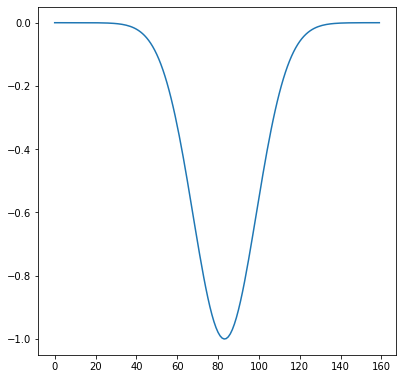

In [ ]:
#plt.plot(net_u[0,0])
plt.figure(figsize=(6.4,6.4))
plt.plot(ref_u[0,0])
plt.savefig('imagens/ordem conv ds funcao.png')

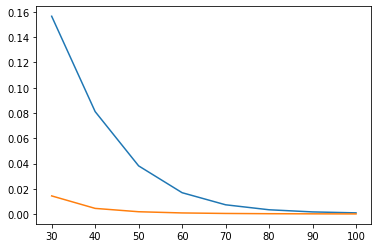

In [ ]:
plt.plot(sizes,error1)
plt.plot(sizes,error2)

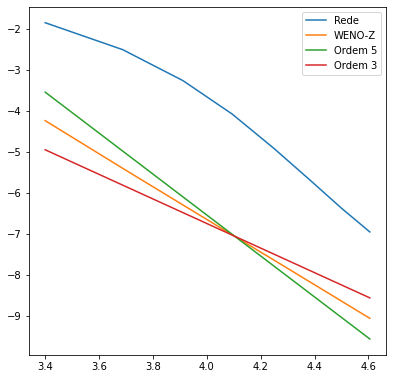

In [ ]:
plt.figure(figsize=(6.4,6.4))

plt.plot(np.log(sizes),np.log(error1),label='Rede')
plt.plot(np.log(sizes),np.log(error2),label='WENO-Z')
#plt.plot(np.log(sizes),np.log(error3),label='WENO-JS')
plt.plot(np.log(sizes),-5*(np.log(sizes)-np.mean(np.log(sizes)))+np.mean(np.log(error2)),label='Ordem 5')
plt.plot(np.log(sizes),-3*(np.log(sizes)-np.mean(np.log(sizes)))+np.mean(np.log(error2)),label='Ordem 3')
plt.legend()

#plt.savefig('imagens/ordem conv ds.png')

In [ ]:
Sim, Sim_step, DerivadaEspacial, Get_weights=create_simulation(API_Numpy,equation,WENO_Z)
WENO_Z_ref=lambda u0, Δx:DerivadaEspacial(u0,Δx, FronteiraFixa)

In [ ]:
Δx_ref = 0.01

def f(x):
    return np.sin(np.pi*x)

def df(x):
    return np.pi*np.cos(np.pi*x)


In [ ]:
Δx1 = Δx_ref
x1  = np.arange(-1, 1, Δx1)
x1  = np.expand_dims(x1,0)
u1  = f(x1)
du1 = df(x1)
y1=WENO_network(u1, Δx1)

print(u1.shape)

(1, 200)


In [ ]:
Δx2 = Δx_ref/2
x2  = np.arange(-1, 1, Δx2)
x2  = np.expand_dims(x2,0)
u2  = f(x2)
du2 = df(x2)
y2=WENO_network(u2, Δx2)

print(u2.shape)

(1, 400)


In [ ]:
# Gerando os gráficos a partir de funções do matplotlib

print(np.sum(abs(y1 - du1))/np.sum(abs(y2 - du2)))

0.49998867338114705
